# 1. Packages laden und globale Variablen initialisieren

In [94]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from meteostat import Point, Daily
import holidays
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# validation variable
validation_range = 3

# Initialisiere eine Liste, in der die Modellmetriken gespeichert werden
model_results = []

# 2. Datensätze vorbereiten

## 1. Datensätze laden

In [95]:
# Zeitraum definieren
start = datetime(2015, 1, 1)
end = datetime(2022, 12, 31)

# Definiere repräsentative Städte (Nord, Süd, West, Ost, Mitte)
locations = {
    "Berlin": Point(52.5200, 13.4050),
    "Hamburg": Point(53.5511, 9.9937),
    "Munich": Point(48.1351, 11.5820),
    "Cologne": Point(50.9375, 6.9603),
    "Leipzig": Point(51.3397, 12.3731)
}

# Leere Liste für DataFrames
dfs = []

# Lade und verarbeite Daten für jede Stadt
for city, point in locations.items():
    data = Daily(point, start, end).fetch()
    data['date'] = pd.to_datetime(data.index)
    df = data[['date', 'tavg', 'tsun']].reset_index(drop=True)
    df.columns = ['date', f'temp_{city}', f'sun_{city}']
    dfs.append(df)

# Merge aller Städte über das Datum
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date'), dfs)

# Berechne den Durchschnitt über alle Städte
df_weather = pd.DataFrame()
df_weather['date'] = df_merged['date']
df_weather['temp_avg'] = df_merged[[f'temp_{city}' for city in locations]].mean(axis=1)
df_weather['sunshine_minutes'] = df_merged[[f'sun_{city}' for city in locations]].mean(axis=1)

# Umrechnung in Sonnenstunden
df_weather['sunshine_hours'] = df_weather['sunshine_minutes'] / 60


# Definiere das Land (z. B. Deutschland)
de_holidays = holidays.Germany(years=range(2015, 2023))

# Erstelle DataFrame mit allen Tagen
all_days = pd.date_range('2015-01-01', '2022-12-31', freq='D')

# Markiere, ob der Tag ein Feiertag ist
df_weekday = pd.DataFrame(all_days, columns=['date'])
df_weekday['is_holiday'] = df_weekday['date'].isin(de_holidays.keys())

# Markiere, ob der Tag ein Wochenende ist
df_weekday['is_weekend'] = df_weekday['date'].dt.weekday >= 5

# Füge eine Spalte für normalen Wochentag hinzu
df_weekday['is_weekday'] = ~df_weekday['is_weekend'] & ~df_weekday['is_holiday']

# Lade den Stromverbrauchsdatensatz
df_strom = pd.read_csv("Datasets/Realisierter_Stromverbrauch_201501010000_202504010000_Tag.csv", sep=";")

## 2. Datensätze explorieren

In [96]:
display(df_weather.head())
df_weather.info()
df_weather.describe()

,date,temp_avg,sunshine_minutes,sunshine_hours
0,2015-01-01,1.96,282.0,4.70
1,2015-01-02,4.46,49.2,0.82
2,2015-01-03,3.70,0.0,0.00
3,2015-01-04,3.12,168.0,2.80
4,2015-01-05,2.80,106.8,1.78


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2922 non-null   datetime64[ns]
 1   temp_avg          2922 non-null   float64       
 2   sunshine_minutes  2922 non-null   float64       
 3   sunshine_hours    2922 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 91.4 KB


,date,temp_avg,sunshine_minutes,sunshine_hours
count,2922,2922.000000,2922.000000,2922.000000
mean,2018-12-31 12:00:00,11.105407,297.849692,4.964162
min,2015-01-01 00:00:00,-8.800000,0.000000,0.000000
25%,2016-12-31 06:00:00,5.340000,106.800000,1.780000
50%,2018-12-31 12:00:00,10.700000,250.800000,4.180000
75%,2020-12-30 18:00:00,17.080000,459.600000,7.660000
max,2022-12-31 00:00:00,28.660000,909.600000,15.160000
std,NaN,7.084512,224.592183,3.743203


In [97]:
display(df_weekday.head())
df_weekday.info()
df_weekday.describe()

,date,is_holiday,is_weekend,is_weekday
0,2015-01-01,True,False,False
1,2015-01-02,False,False,True
2,2015-01-03,False,True,False
3,2015-01-04,False,True,False
4,2015-01-05,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2922 non-null   datetime64[ns]
 1   is_holiday  2922 non-null   bool          
 2   is_weekend  2922 non-null   bool          
 3   is_weekday  2922 non-null   bool          
dtypes: bool(3), datetime64[ns](1)
memory usage: 31.5 KB


,date
count,2922
mean,2018-12-31 12:00:00
min,2015-01-01 00:00:00
25%,2016-12-31 06:00:00
50%,2018-12-31 12:00:00
75%,2020-12-30 18:00:00
max,2022-12-31 00:00:00


In [98]:
display(df_strom.head())
df_strom.info()
df_strom.describe()

,Datum von,Datum bis,Netzlast [MWh] Berechnete Auflösungen,Netzlast inkl. Pumpspeicher [MWh] Berechnete Auflösungen,Pumpspeicher [MWh] Berechnete Auflösungen,Residuallast [MWh] Berechnete Auflösungen
0,01.01.2015,02.01.2015,"1.096.852,75","1.122.748,25","25.895,50","768.472,25"
1,02.01.2015,03.01.2015,"1.288.914,75","1.316.139,75","27.225,00","679.205,75"
2,03.01.2015,04.01.2015,"1.213.309,50","1.238.003,75","24.694,25","736.911,75"
3,04.01.2015,05.01.2015,"1.177.896,00","1.202.337,75","24.441,75","767.345,50"
4,05.01.2015,06.01.2015,"1.425.927,50","1.451.660,75","25.733,25","1.172.036,25"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3743 entries, 0 to 3742
Data columns (total 6 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Datum von                                                 3743 non-null   object
 1   Datum bis                                                 3743 non-null   object
 2   Netzlast [MWh] Berechnete Auflösungen                     3743 non-null   object
 3   Netzlast inkl. Pumpspeicher [MWh] Berechnete Auflösungen  3743 non-null   object
 4   Pumpspeicher [MWh] Berechnete Auflösungen                 3743 non-null   object
 5   Residuallast [MWh] Berechnete Auflösungen                 3743 non-null   object
dtypes: object(6)
memory usage: 175.6+ KB


,Datum von,Datum bis,Netzlast [MWh] Berechnete Auflösungen,Netzlast inkl. Pumpspeicher [MWh] Berechnete Auflösungen,Pumpspeicher [MWh] Berechnete Auflösungen,Residuallast [MWh] Berechnete Auflösungen
count,3743,3743,3743,3743,3743,3743
unique,3743,3743,3739,3738,3698,3743
top,31.03.2025,01.04.2025,"1.428.687,25","1.581.840,50","35.252,50","757.921,25"
freq,1,1,2,2,3,1


## 3. Datensätze zusammenführen

In [99]:
# Sicherstellen, dass Datumsspalten im richtigen Format vorliegen
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_strom['Datum von'] = pd.to_datetime(df_strom['Datum von'], format='%d.%m.%Y')
df_weekday['date'] = pd.to_datetime(df_weekday['date'])

# Zusammenführen der beiden Datensätze basierend auf dem Datum
df_combined = pd.merge(df_weather, df_strom, left_on='date', right_on='Datum von', how='inner')
df_combined = pd.merge(df_combined, df_weekday, on='date', how='inner')

# Entfernen der redundanten Spalte 'Datum von' und anderen irrelevanten Spalten
df_combined = df_combined.drop(columns=['Datum von', 'Datum bis', 'sunshine_minutes', 'Netzlast inkl. Pumpspeicher [MWh] Berechnete Auflösungen', 'Pumpspeicher [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen' ])
df_combined.rename(columns={'Netzlast [MWh] Berechnete Auflösungen': 'mains_load'}, inplace=True)

# Convert the 'mains_load' column to float after replacing commas with dots and removing periods
df_combined['mains_load'] = df_combined['mains_load'].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

# Vorschau des kombinierten DataFrames
df_combined.head()

,date,temp_avg,sunshine_hours,mains_load,is_holiday,is_weekend,is_weekday
0,2015-01-01,1.96,4.70,1096852.75,True,False,False
1,2015-01-02,4.46,0.82,1288914.75,False,False,True
2,2015-01-03,3.70,0.00,1213309.50,False,True,False
3,2015-01-04,3.12,2.80,1177896.00,False,True,False
4,2015-01-05,2.80,1.78,1425927.50,False,False,True


In [100]:
# combined data preview
display(df_combined.info())
display(df_combined.describe())
df_combined.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2922 non-null   datetime64[ns]
 1   temp_avg        2922 non-null   float64       
 2   sunshine_hours  2922 non-null   float64       
 3   mains_load      2922 non-null   float64       
 4   is_holiday      2922 non-null   bool          
 5   is_weekend      2922 non-null   bool          
 6   is_weekday      2922 non-null   bool          
dtypes: bool(3), datetime64[ns](1), float64(3)
memory usage: 100.0 KB


None

,date,temp_avg,sunshine_hours,mains_load
count,2922,2922.000000,2922.000000,2.922000e+03
mean,2018-12-31 12:00:00,11.105407,4.964162,1.364771e+06
min,2015-01-01 00:00:00,-8.800000,0.000000,9.647645e+05
25%,2016-12-31 06:00:00,5.340000,1.780000,1.253363e+06
50%,2018-12-31 12:00:00,10.700000,4.180000,1.385586e+06
75%,2020-12-30 18:00:00,17.080000,7.660000,1.483986e+06
max,2022-12-31 00:00:00,28.660000,15.160000,1.729547e+06
std,NaN,7.084512,3.743203,1.600863e+05


date              0
temp_avg          0
sunshine_hours    0
mains_load        0
is_holiday        0
is_weekend        0
is_weekday        0
dtype: int64

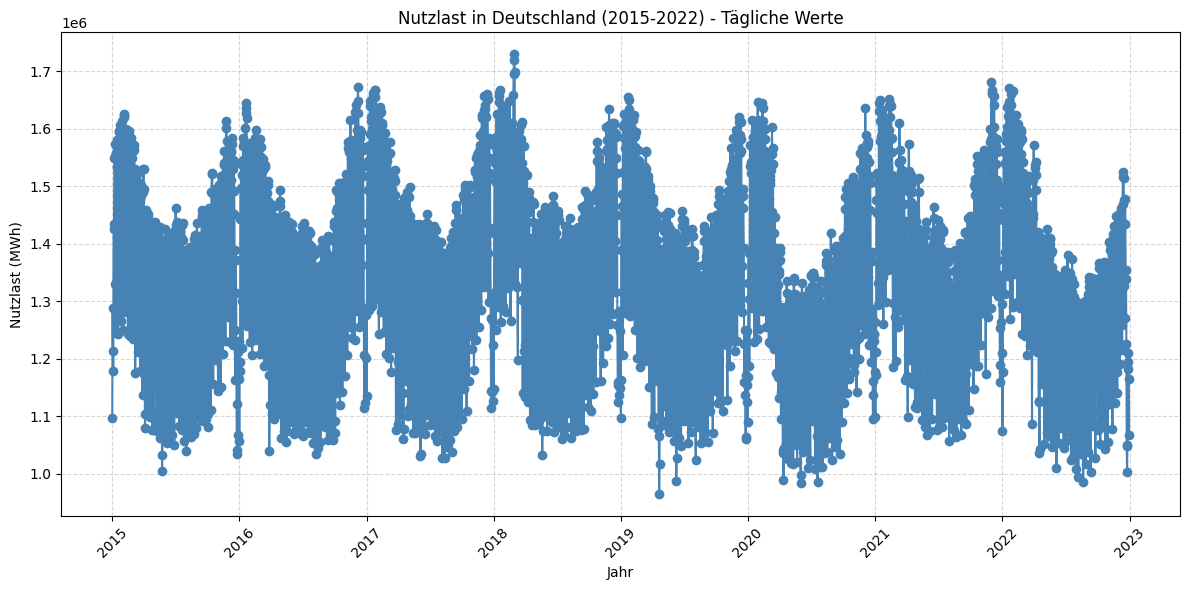

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(df_combined['date'], df_combined['mains_load'], marker='o', color='Steelblue')
plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Nutzlast in Deutschland (2015-2022) - Tägliche Werte')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 4. Datenaggregation

In [102]:
# Sicherstellen, dass 'date' im datetime-Format ist
df_combined['date'] = pd.to_datetime(df_combined['date'])

# Neue Spalte mit dem Monatsanfang erstellen
df_combined['month'] = df_combined['date'].values.astype('datetime64[M]')

# Aggregation nach Monat
df_monthly = df_combined.groupby('month').agg({
    'temp_avg': 'mean',
    'sunshine_hours': 'sum',
    'mains_load': 'sum',
    'is_holiday': 'sum',
    'is_weekend': 'sum',
    'is_weekday': 'sum'
}).reset_index()

# Die Spalte 'month' als 'date' benennen, um sie weiter als Datumsbezug zu verwenden
df_monthly.rename(columns={'month': 'date'}, inplace=True)

# Berechnung der Anzahl der Monate seit dem Startdatum
df_monthly['months_since_start'] = (df_monthly['date'].dt.year - start.year) * 12 + (df_monthly['date'].dt.month - start.month)

# Entferne die letzten x Monate für die Validierung
cutoff_date = df_monthly['date'].max() - pd.DateOffset(months=10) # 6 oder 10
df_monthly = df_monthly[df_monthly['date'] <= cutoff_date].copy()

# Vorschau des aggregierten DataFrames
df_monthly.head()


,date,temp_avg,sunshine_hours,mains_load,is_holiday,is_weekend,is_weekday,months_since_start
0,2015-01-01,3.225161,40.98,45142690.25,1,9,21,0
1,2015-02-01,1.846429,93.74,42095506.50,0,8,20,1
2,2015-03-01,6.196774,132.78,44331785.00,0,9,22,2
3,2015-04-01,9.539333,225.04,40041540.00,2,8,20,3
4,2015-05-01,13.412258,187.50,39296911.00,3,10,18,4


## 5. Visualisierung der Zielgröße

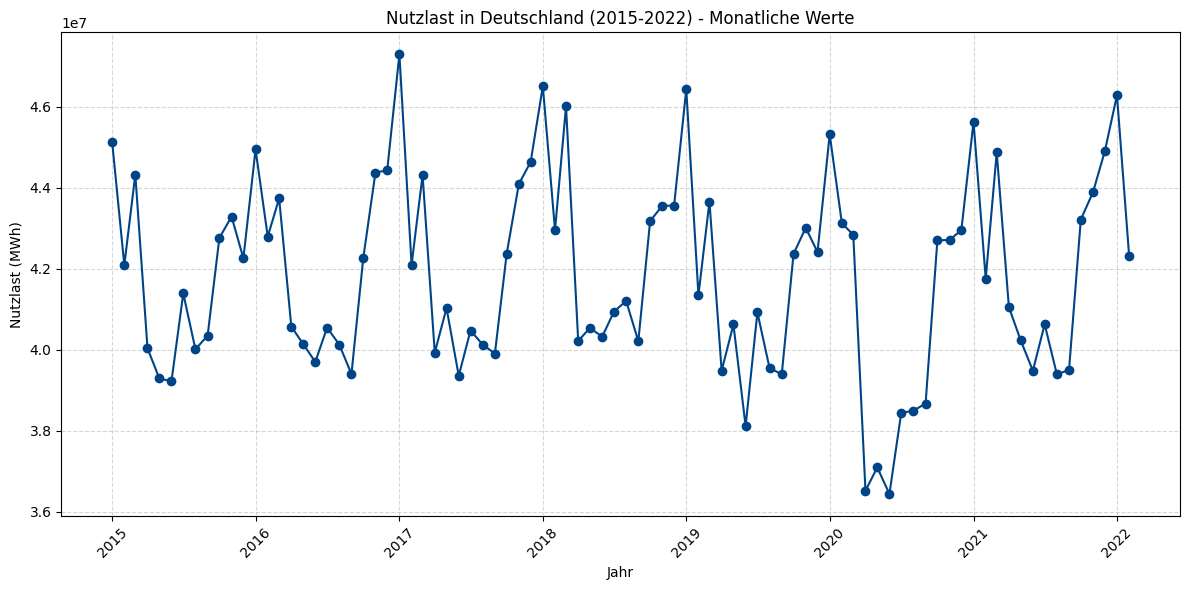

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['date'], df_monthly['mains_load'], marker='o', color='#004488')
plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Nutzlast in Deutschland (2015-2022) - Monatliche Werte')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Modelle trainieren

## 1. Lineare Regression

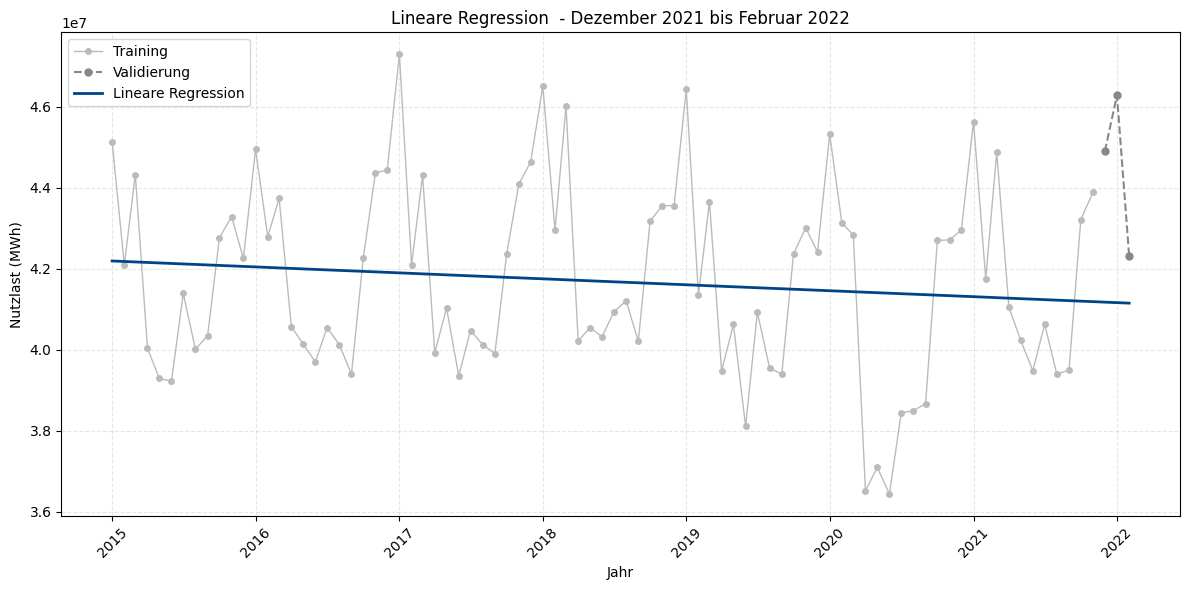

Mean Absolute Percentage Error (MAPE): 7.37%
Mean Absolute Deviation (MAD): 3335015.74


In [104]:
#Datensatz gessamt
X_all = df_monthly[['months_since_start']]
y_all = df_monthly['mains_load']

#Datensatz Training 
X_train = df_monthly.iloc[:-validation_range][['months_since_start']]
y_train = df_monthly.iloc[:-validation_range]['mains_load']

#Datensatz Validierung 
X_valid = df_monthly.iloc[-validation_range:][['months_since_start']]
y_valid = df_monthly.iloc[-validation_range:]['mains_load']

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_all)

# Plot im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], y_train, label='Training',
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], y_valid, label='Validierung',
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Modellvorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred, label='Lineare Regression',
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Lineare Regression  - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((y_valid - y_pred[-validation_range:]) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Lineare Regression',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")

## 2. Lineare Regression mit Saisoneffekten

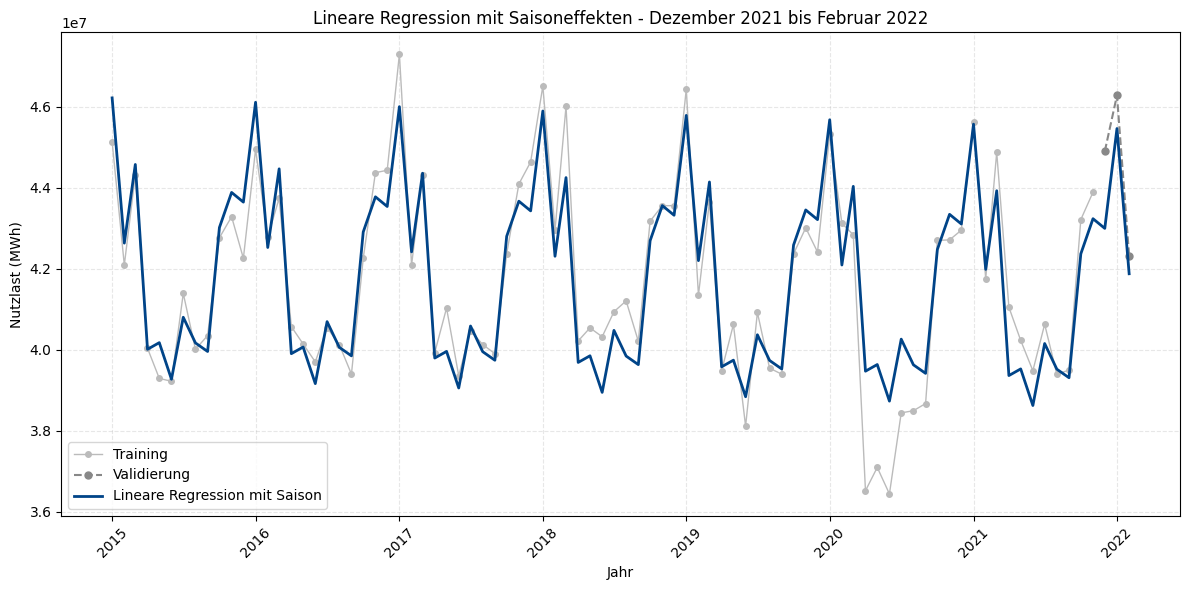

Mean Absolute Percentage Error (MAPE): 2.35%
Mean Absolute Deviation (MAD): 1052586.96


In [105]:
# Monat extrahieren für One-Hot-Encoding
df_monthly['month'] = df_monthly['date'].dt.month

# One-Hot-Encoding der Monate (Saisoneffekt)
df_with_dummies = pd.get_dummies(df_monthly, columns=['month'], drop_first=True)

# Features für das Modell
feature_cols = ['months_since_start'] + [col for col in df_with_dummies.columns if col.startswith('month_')]

X_all = df_with_dummies[feature_cols]
y_all = df_with_dummies['mains_load']

# Training
X_train = X_all.iloc[:-validation_range]
y_train = y_all.iloc[:-validation_range]

# Validierung
X_valid = X_all.iloc[-validation_range:]
y_valid = y_all.iloc[-validation_range:]

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_all)

# Plotten im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], y_train, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], y_valid, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Modellvorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred, label='Lineare Regression mit Saison', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Lineare Regression mit Saisoneffekten - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((y_valid - y_pred[-validation_range:]) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Lineare Regression mit Saisoneffekten',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")

## 3. Lineare Regression mit Saisoneffekten und Kausalvariablen

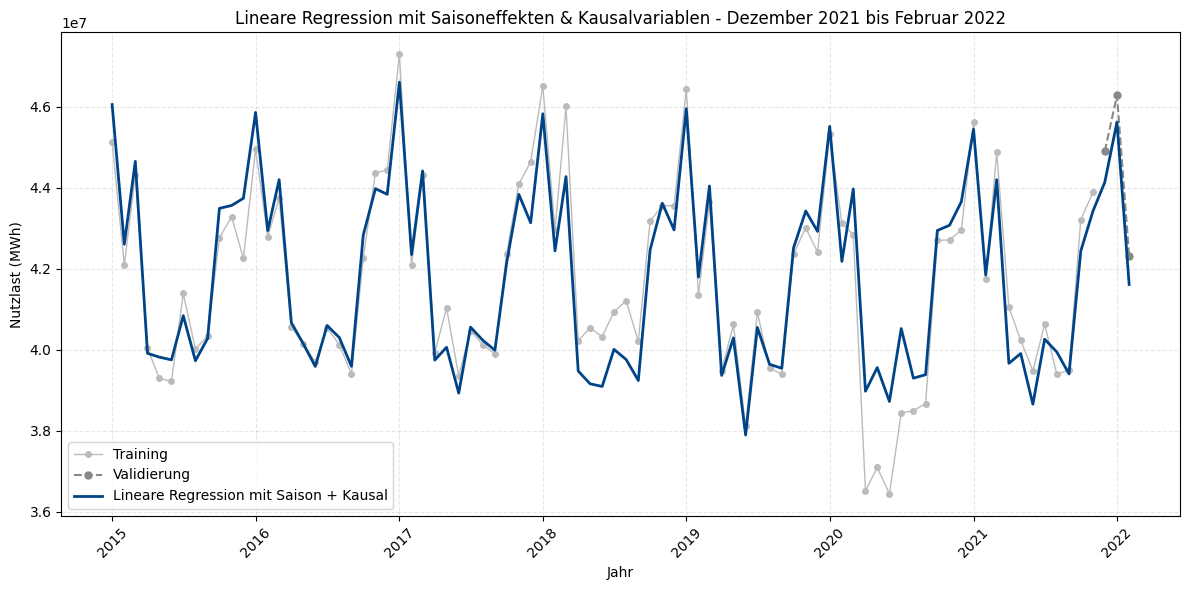

Mean Absolute Percentage Error (MAPE): 1.59%
Mean Absolute Deviation (MAD): 707366.25


In [106]:
# Monat als neue Spalte hinzufügen (für Dummies)
df_monthly['month'] = df_monthly['date'].dt.month

# One-Hot-Encoding der Monate (Saisoneffekt)
df_with_dummies = pd.get_dummies(df_monthly, columns=['month'], drop_first=True)

# Features für das Modell: Zeit + Saison (Monatsdummies) + Kausalvariablen
feature_cols = (
    ['months_since_start'] +
    [col for col in df_with_dummies.columns if col.startswith('month_')] +
    ['temp_avg', 'sunshine_hours', 'is_holiday', 'is_weekend', 'is_weekday']
)

X_all = df_with_dummies[feature_cols]
y_all = df_with_dummies['mains_load']

# Training
X_train = X_all.iloc[:-validation_range]
y_train = y_all.iloc[:-validation_range]

# Validierung
X_valid = X_all.iloc[-validation_range:]
y_valid = y_all.iloc[-validation_range:]

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_all)

# Plotten für Forecast-/Prognosekontext
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], y_train, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont, aber nicht dominant
plt.plot(df_monthly['date'][-validation_range:], y_valid, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Modellvorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred, label='Lineare Regression mit Saison + Kausal', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Lineare Regression mit Saisoneffekten & Kausalvariablen - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((y_valid - y_pred[-validation_range:]) / y_valid)) * 100
mad = np.mean(np.abs(y_valid - y_pred[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Lineare Regression mit Saisoneffekten & Kausalvariablen',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad:.2f}")


## 4. Simple Exponential Smoothing

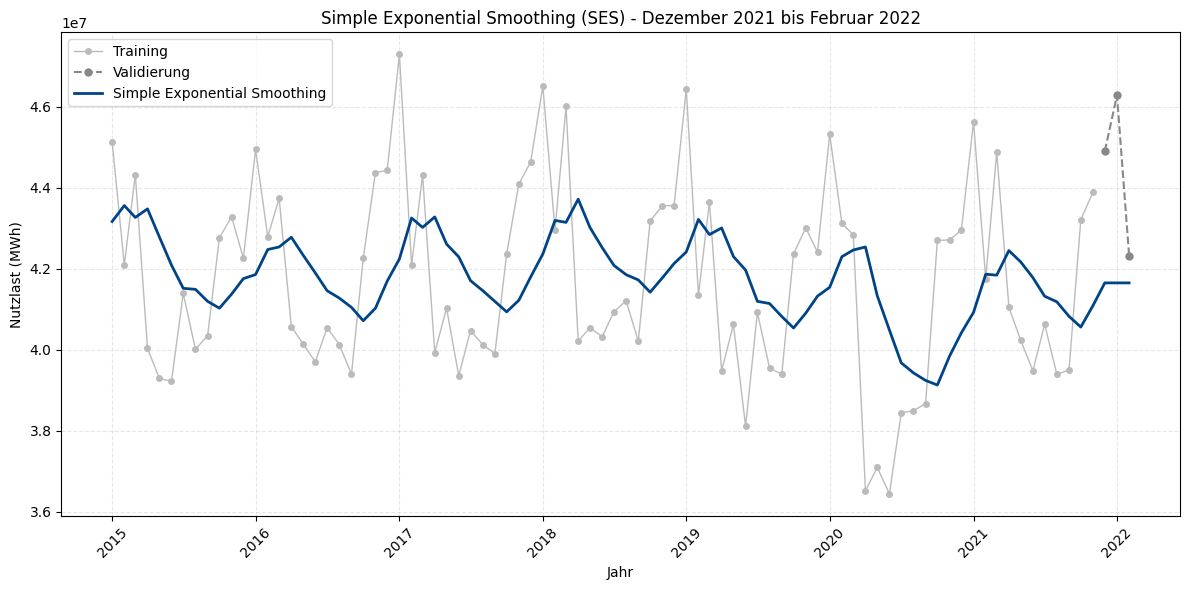

Mean Absolute Percentage Error (MAPE) - SES: 6.27%
Mean Absolute Deviation (MAD) - SES: 2847529.44


In [107]:
# Training
train_data = df_monthly['mains_load'][:-validation_range]

# Modell erstellen und trainieren (Simple Exponential Smoothing)
model_ses = SimpleExpSmoothing(train_data, initialization_method="estimated")
model_ses_fitted = model_ses.fit(smoothing_level=0.2, optimized=True)  # smoothing_level anpassbar

# Vorhersagen für den gesamten Datensatz erstellen
y_pred_ses = model_ses_fitted.predict(start=df_monthly.index[0], end=df_monthly.index[-1])

# Plotten im konsistenten Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], df_monthly['mains_load'][-validation_range:], 
         label='Validierung', marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# SES-Vorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred_ses, label='Simple Exponential Smoothing', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('Simple Exponential Smoothing (SES) - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((df_monthly['mains_load'][-validation_range:] - y_pred_ses[-validation_range:]) / df_monthly['mains_load'][-12:])) * 100
mad = np.mean(np.abs(df_monthly['mains_load'][-validation_range:] - y_pred_ses[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Simple Exponential Smoothing (SES)',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - SES: {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD) - SES: {mad:.2f}")

## 5. Double Exponential Smoothing (Holt's Method)

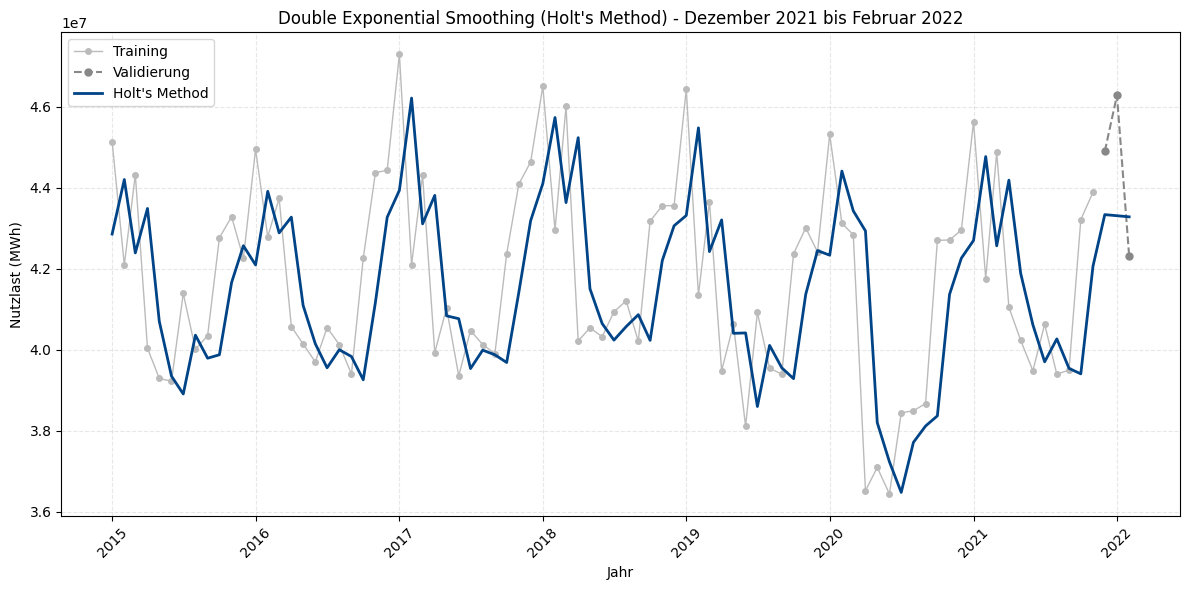

Mean Absolute Percentage Error (MAPE) - Holt: 4.06%
Mean Absolute Deviation (MAD) - Holt: 1834583.43


In [108]:
# Zielvariable
series = df_monthly['mains_load']

# Datasets
train_data = series.iloc[:-validation_range]
valid_data = series.iloc[-validation_range:]

# Holt's Linear Trend Modell (Double Exponential Smoothing)
holt_model = ExponentialSmoothing(train_data, trend="add", seasonal=None, initialization_method="estimated")
holt_fit = holt_model.fit()

# Prognose für den gesamten Zeitraum (inkl. Validierung)
y_pred_holt = holt_fit.predict(start=series.index[0], end=series.index[-1])

# Plotten im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Holt's Forecast – im Fokus
plt.plot(df_monthly['date'], y_pred_holt, label="Holt's Method", 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("Double Exponential Smoothing (Holt's Method) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((valid_data - y_pred_holt[-validation_range:]) / valid_data)) * 100
mad = np.mean(np.abs(valid_data - y_pred_holt[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Double Exponential Smoothing (Holt)',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - Holt: {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD) - Holt: {mad:.2f}")

## 6. Triple Exponential Smoothing (Holt-Winters - Additiv)

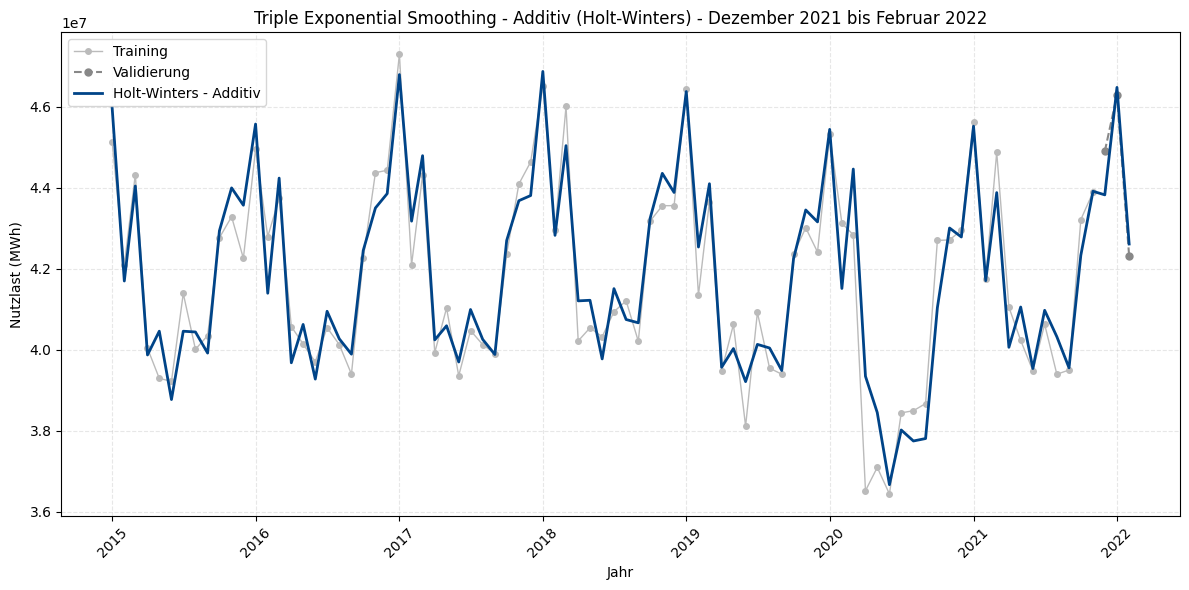

Mean Absolute Percentage Error (MAPE) - Holt-Winters: 1.17%
Mean Absolute Deviation (MAD) - Holt-Winters: 522783.07


In [109]:
# Zielvariable
series = df_monthly['mains_load']

# Daten aufteilen
train_data = series.iloc[:-validation_range]
valid_data = series.iloc[-validation_range:]

# Holt-Winters Modell mit additiver Saisonalität
hw_model = ExponentialSmoothing(
    train_data,
    trend="add",
    seasonal="add",
    seasonal_periods=12,  # Annahme: Monatsdaten, daher 12 Perioden
    initialization_method="estimated"
)
hw_fit = hw_model.fit()

# Vorhersage über den gesamten Zeitraum
y_pred_hw = hw_fit.predict(start=series.index[0], end=series.index[-1])

# Plot im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Holt-Winters Vorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred_hw, label='Holt-Winters - Additiv', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("Triple Exponential Smoothing - Additiv (Holt-Winters) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf Validierungsdaten)
mape = np.mean(np.abs((valid_data - y_pred_hw[-validation_range:]) / valid_data)) * 100
mad = np.mean(np.abs(valid_data - y_pred_hw[-validation_range:]))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Triple Exponential Smoothing - Additiv (Holt-Winters)',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - Holt-Winters: {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD) - Holt-Winters: {mad:.2f}")

## 7. Triple Exponential Smoothing (Holt-Winters - Multiplikativ)

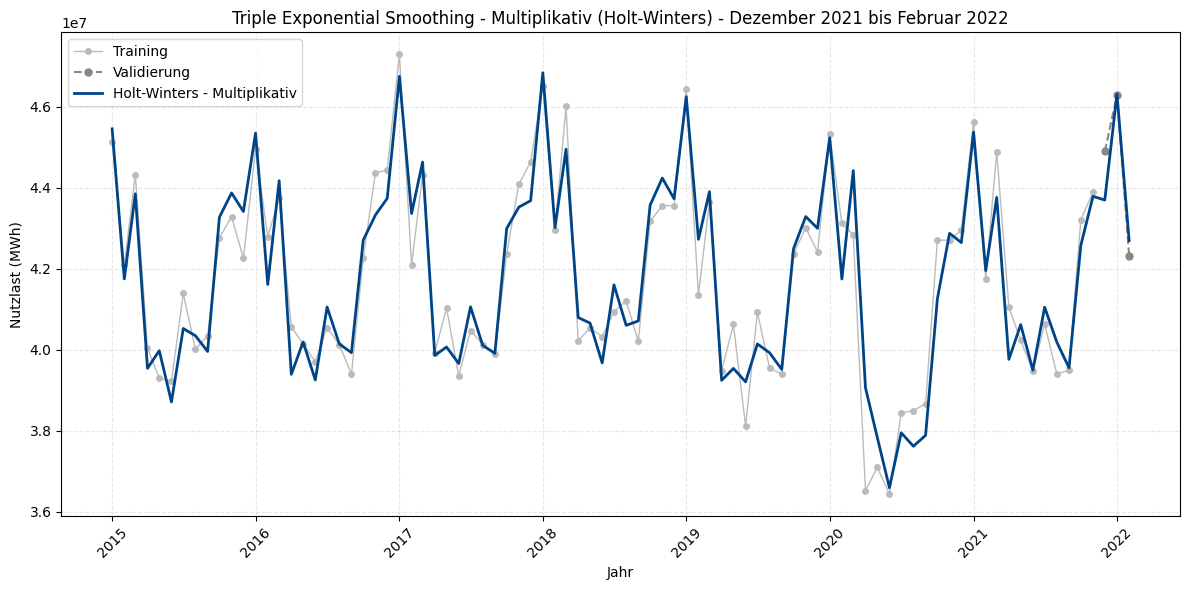

Mean Absolute Percentage Error (MAPE) - Holt-Winters Multiplikativ: 1.22%
Mean Absolute Deviation (MAD) - Holt-Winters Multiplikativ: 538707.75


In [110]:
# Log-Transformation der Zielvariable
series_log = np.log(df_monthly['mains_load'])

# Daten aufteilen
train_log = series_log.iloc[:-validation_range]
valid_log = series_log.iloc[-validation_range:]

# Holt-Winters Modell auf log-Skala (additive Komponenten ≈ multiplikativ im Original)
hw_log_model = ExponentialSmoothing(
    train_log,
    trend="add",
    seasonal="mul",
    seasonal_periods=12,
    initialization_method="estimated"
)
hw_log_fit = hw_log_model.fit()

# Vorhersage auf log-Skala
y_pred_log = hw_log_fit.predict(start=series_log.index[0], end=series_log.index[-1])

# Rücktransformation auf Originalskala
y_pred_hw_mul = np.exp(y_pred_log)

# Plot im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], np.exp(train_log), label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], np.exp(valid_log), label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# Holt-Winters Multiplikativ Vorhersage – im Fokus
plt.plot(df_monthly['date'], y_pred_hw_mul, label='Holt-Winters - Multiplikativ', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("Triple Exponential Smoothing - Multiplikativ (Holt-Winters) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (auf Originalskala)
valid_actual = np.exp(valid_log)
valid_predicted = y_pred_hw_mul[-validation_range:]

mape = np.mean(np.abs((valid_actual - valid_predicted) / valid_actual)) * 100
mad = np.mean(np.abs(valid_actual - valid_predicted))

# Ergebnisse speichern
model_results.append({
    'Modell': 'Triple Exponential Smoothing - Multiplikativ (Holt-Winters)',
    'MAPE': round(mape, 2),
    'MAD': round(mad, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - Holt-Winters Multiplikativ: {mape:.2f}%")
print(f"Mean Absolute Deviation (MAD) - Holt-Winters Multiplikativ: {mad:.2f}")

## ARIMA Vorbereitung

### ACF-Plot

<Figure size 1000x400 with 0 Axes>

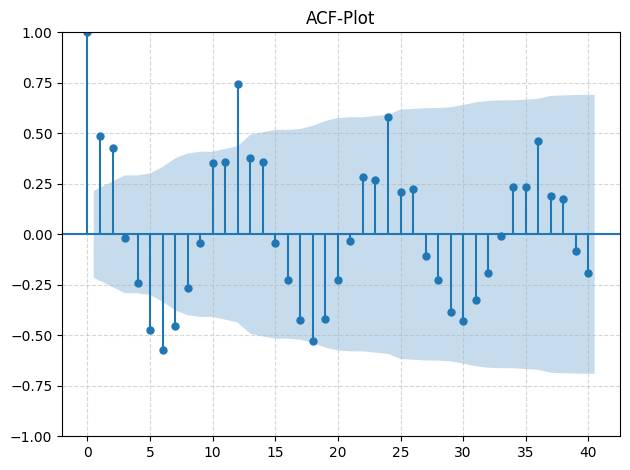

In [111]:
X_train = df_monthly.iloc[:-validation_range][['months_since_start']]
y_train = df_monthly.iloc[:-validation_range]['mains_load']

plt.figure(figsize=(10, 4))
plot_acf(y_train, lags=40, alpha=0.05)
plt.title('ACF-Plot')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### PACF-Plot

<Figure size 1000x400 with 0 Axes>

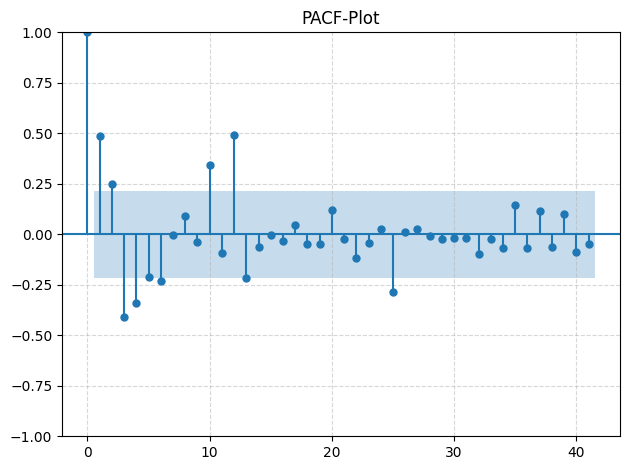

In [112]:
X_train = df_monthly.iloc[:-validation_range][['months_since_start']]
y_train = df_monthly.iloc[:-validation_range]['mains_load']

# Berechne die Anzahl der verfügbaren Lags (50% der Trainingsgröße)
max_lags = len(y_train) // 2

# Setze die Anzahl der Lags auf max_lags
plt.figure(figsize=(10, 4))
plot_pacf(y_train, lags=max_lags, method='ywm', alpha=0.05)
plt.title('PACF-Plot')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Weitere Tests

#### Box-Ljung-Test

In [113]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Box-Ljung-Test (hier auf den Residuen der Zeitreihe selbst – du kannst ggf. differenzieren, wenn nicht stationär)
ljung_box_result = acorr_ljungbox(y_train.dropna(), lags=[10], return_df=True)

# Ergebnis anzeigen
print("\nBox-Ljung-Test Ergebnis:")
print(ljung_box_result)


Box-Ljung-Test Ergebnis:
       lb_stat     lb_pvalue
10  129.692067  5.398158e-23


H₀ (Nullhypothese): Es gibt keine Autokorrelation bis zum angegebenen Lag (hier Lag 10).

lb_stat = 153.09: Das ist der Ljung-Box-Teststatistik-Wert. Allein sagt der dir nicht viel – entscheidend ist der p-Wert.
lb_pvalue = 8.61e-28: Das ist extrem niedrig – also viel kleiner als gängige Signifikanzniveaus wie 0.05 oder 0.01.

Da der p-Wert extrem klein ist, verwerfen wir die Nullhypothese.
→ Deine Zeitreihe weist signifikante Autokorrelationen bis mindestens Lag 10 auf.
Das bedeutet: Die Werte in y_train sind nicht rein zufällig, sondern haben ein strukturelles, zeitlich abhängiges Muster.

#### ADF-Test

In [114]:
X_train = df_monthly.iloc[:-validation_range][['months_since_start']]
y_train = df_monthly.iloc[:-validation_range]['mains_load']

# ADF-Test
result = adfuller(y_train.dropna())

# Ergebnis anzeigen
print('ADF-Statistik:', result[0])
print('p-Wert:', result[1])
print('Kritische Werte:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')

ADF-Statistik: -1.355617425523781
p-Wert: 0.6033592043495516
Kritische Werte:
   1%: -3.527
   5%: -2.904
   10%: -2.589


#### KPSS-Test

In [115]:
# KPSS-Test
kpss_result = kpss(y_train.dropna(), regression='c')

# Ergebnis anzeigen
print('KPSS-Statistik:', kpss_result[0])
print('p-Wert:', kpss_result[1])
print('Kritische Werte:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value:.3f}')

KPSS-Statistik: 0.10571450656261933
p-Wert: 0.1
Kritische Werte:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


look-up table. The actual p-value is greater than the p-value returned.



### Interpretation der Plots

1. Stationarität der Zeitreihe

🔹 ADF-Test: ADF-Statistik: -1.52, p-Wert: 0.524
→ Der p-Wert ist deutlich größer als 0.05, daher kein Hinweis auf Stationarität → Nullhypothese wird nicht verworfen

🔹 KPSS-Test: KPSS-Statistik: 0.15, p-Wert: > 0.1
→ p-Wert ist größer als 0.05, daher kein Hinweis auf Nicht-Stationarität → Nullhypothese (stationär) wird nicht verworfen

🟡 Fazit: Widersprüchliche Tests (kommt manchmal vor)

🔹 Der ADF-Test deutet auf Nicht-Stationarität

🔹 Der KPSS-Test dagegen auf Stationarität

👉 Vorsichtiger Umgang empfohlen → in solchen Fällen empfiehlt es sich, mindestens eine Differenzierung zu versuchen (d.h. d = 1) und erneut zu testen.

2. ACF-Plot (Autokorrelation)

🔹 Hohe Signifikanz bei Lag 1 und 2

🔹 Auch Lag 6, 11, 18, 36 zeigen auffällige Peaks (Hinweise auf saisonale Muster?)

🔹 Danach langsames Abfallen → typisch für AR-Prozesse

🧠 Interpretation für MA-Komponente:

🔹 Ein MA(q)-Prozess zeigt abrupten Abfall nach Lag q.

🔹 Da der Abfall nicht abrupt ist, sondern langsam, sieht es nicht nach einem MA-Prozess aus.

🔹 Schlussfolgerung: q = 0 oder 1 (wir testen später ggf. mehrere)

3. PACF-Plot (Partielle Autokorrelation)

🔹Starke Spitze bei Lag 1, danach deutlich schwächer

🔹Abfall nach Lag 1 → typisches Verhalten eines AR(1)-Prozesses

🔹Danach viele Werte innerhalb des Konfidenzintervalls

🧠 Interpretation für AR-Komponente:

🔹AR(p)-Prozesse haben Signifikanz im PACF bei niedrigen Lags und dann ein schnelles Abfallen.

🔹Genau das ist hier der Fall → AR(1) ist plausibel.

Komponente | Wert | Begründung
p (AR) | 1 | Starker Peak in PACF bei Lag 1, danach kein signifikanter Lag → klassisches AR(1)-Muster
d (Differencing) | 1 | ADF-Test deutet auf Nicht-Stationarität → Differenzieren zur Erreichung von Stationarität
q (MA) | 0 | Kein klarer Cutoff im ACF → kein starker MA-Effekt sichtbar

ARIMA(1,1,0) Das wäre dein Startmodell. Du kannst es mit AIC/BIC oder Kreuzvalidierung gegen andere Modelle wie ARIMA(1,1,1) oder ARIMA(2,1,0) testen.

## 8. ARIMA(1,1,0)

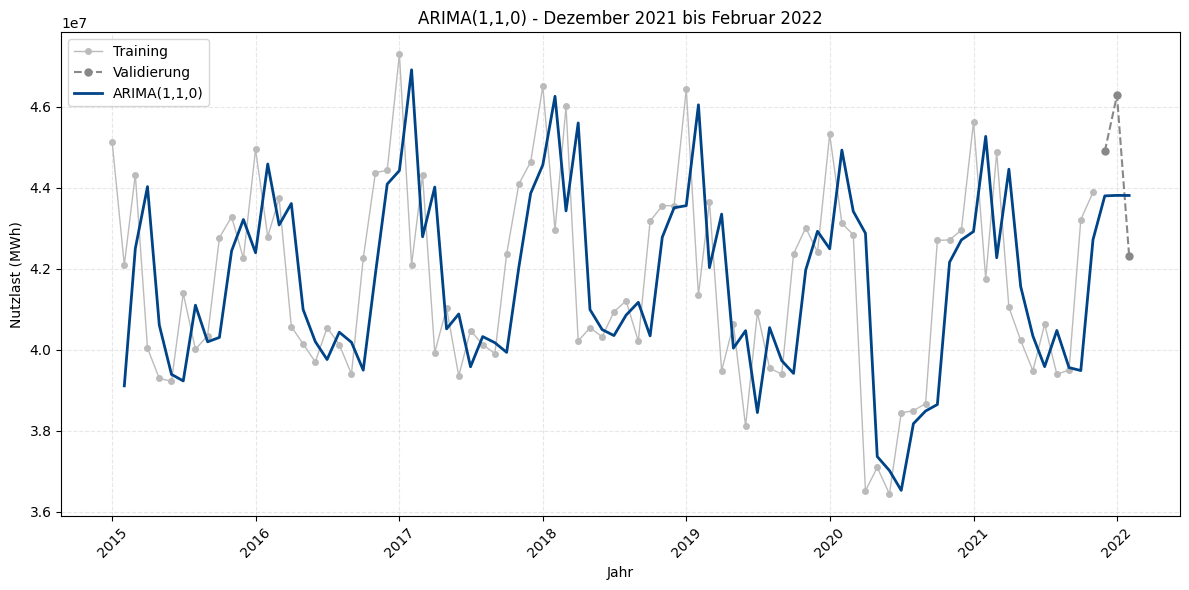

Mean Absolute Percentage Error (MAPE) - ARIMA(1,1,0): 3.77%
Mean Absolute Deviation (MAD) - ARIMA(1,1,0): 1688952.32


In [116]:
# ARIMA(1,1,0) Modell trainieren
arima_model = ARIMA(train_data, order=(1, 1, 0))
arima_fit = arima_model.fit()

# Vorhersage über das gesamte Zeitintervall
pred = arima_fit.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_arima_full = pred.predicted_mean

# Problem: erster Wert ist oft 0 oder unstabil durch Differenzierung
# → wir ignorieren den ersten Prognosewert
y_pred_arima = y_pred_arima_full[1:]
forecast_dates = df_monthly['date'][1:]  # passender Zeitindex für Prognose

# Plot der Vorhersagen im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# ARIMA-Vorhersagen – im Fokus
plt.plot(forecast_dates, y_pred_arima, label='ARIMA(1,1,0)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("ARIMA(1,1,0) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung auf Validierungszeitraum
# Wir nehmen die letzten `validation_range` Werte aus der bereinigten Prognose
valid_forecast = y_pred_arima[-validation_range:]

mape_arima = np.mean(np.abs((valid_data - valid_forecast) / valid_data)) * 100
mad_arima = np.mean(np.abs(valid_data - valid_forecast))

# Ergebnisse speichern
model_results.append({
    'Modell': 'ARIMA(1,1,0)',
    'MAPE': round(mape_arima, 2),
    'MAD': round(mad_arima, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - ARIMA(1,1,0): {mape_arima:.2f}%")
print(f"Mean Absolute Deviation (MAD) - ARIMA(1,1,0): {mad_arima:.2f}")


## 9. ARIMA(1,1,1)

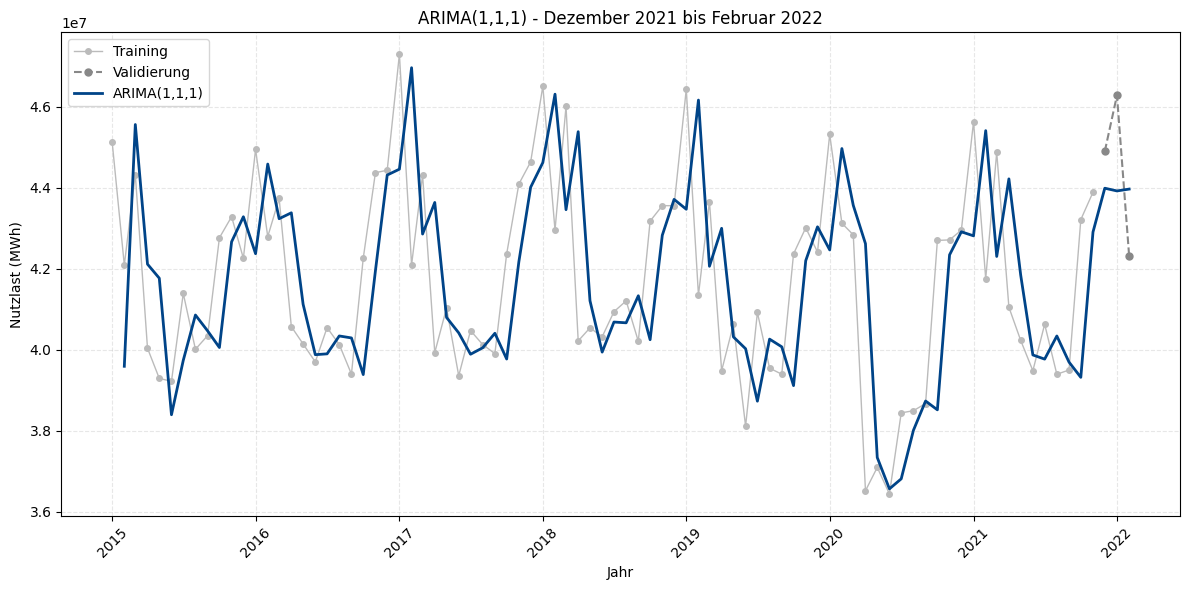

Mean Absolute Percentage Error (MAPE) - ARIMA(1,1,1): 3.68%
Mean Absolute Deviation (MAD) - ARIMA(1,1,1): 1641463.11


In [117]:
# Zielvariable
series = df_monthly['mains_load']

# Trainings- und Validierungsdaten
train_data = series.iloc[:-validation_range]
valid_data = series.iloc[-validation_range:]

# ARIMA(1,1,1) Modell trainieren
arima_model_111 = ARIMA(train_data, order=(1, 1, 1))
arima_fit_111 = arima_model_111.fit()

# Vorhersage über den gesamten Zeitraum
pred_111 = arima_fit_111.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_arima_111_full = pred_111.predicted_mean

# Ersten Prognosewert ignorieren (wegen Differenzierung)
y_pred_arima_111 = y_pred_arima_111_full[1:]
forecast_dates_111 = df_monthly['date'][1:]

# Plotten im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# ARIMA Prognose – im Fokus
plt.plot(forecast_dates_111, y_pred_arima_111, label='ARIMA(1,1,1)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("ARIMA(1,1,1) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung (nur auf den Validierungsdaten)
valid_forecast_111 = y_pred_arima_111[-validation_range:]
mape_arima_111 = np.mean(np.abs((valid_data - valid_forecast_111) / valid_data)) * 100
mad_arima_111 = np.mean(np.abs(valid_data - valid_forecast_111))

# Ergebnisse speichern
model_results.append({
    'Modell': 'ARIMA(1,1,1)',
    'MAPE': round(mape_arima_111, 2),
    'MAD': round(mad_arima_111, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - ARIMA(1,1,1): {mape_arima_111:.2f}%")
print(f"Mean Absolute Deviation (MAD) - ARIMA(1,1,1): {mad_arima_111:.2f}")


## 10. ARIMA(2,1,0)

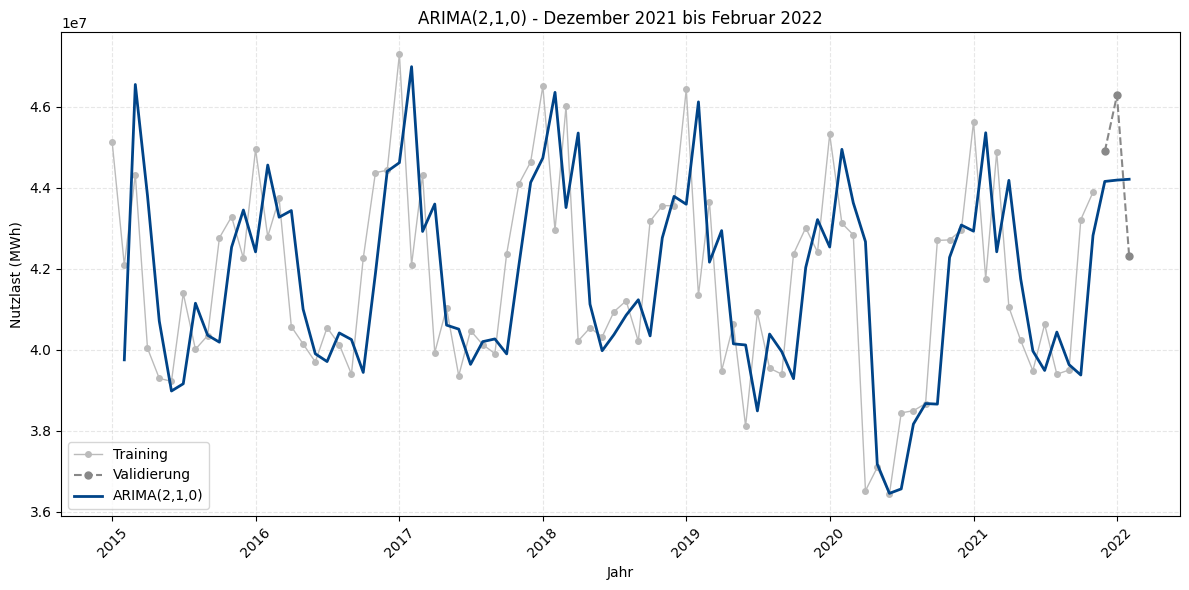

Mean Absolute Percentage Error (MAPE) - ARIMA(2,1,0): 3.55%
Mean Absolute Deviation (MAD) - ARIMA(2,1,0): 1577479.09


In [118]:
# ARIMA(2,1,0) Modell trainieren
arima_model_210 = ARIMA(train_data, order=(2, 1, 0))
arima_fit_210 = arima_model_210.fit()

# Vorhersage über den gesamten Zeitraum
pred_210 = arima_fit_210.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_arima_210_full = pred_210.predicted_mean

# Ersten Prognosewert ignorieren (wegen Differenzierung)
y_pred_arima_210 = y_pred_arima_210_full[1:]
forecast_dates_210 = df_monthly['date'][1:]

# Plot im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# ARIMA Vorhersage – im Fokus
plt.plot(forecast_dates_210, y_pred_arima_210, label='ARIMA(2,1,0)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('ARIMA(2,1,0) - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung auf Validierungszeitraum
valid_forecast_210 = y_pred_arima_210[-validation_range:]
mape_arima_210 = np.mean(np.abs((valid_data - valid_forecast_210) / valid_data)) * 100
mad_arima_210 = np.mean(np.abs(valid_data - valid_forecast_210))

# Ergebnisse speichern
model_results.append({
    'Modell': 'ARIMA(2,1,0)',
    'MAPE': round(mape_arima_210, 2),
    'MAD': round(mad_arima_210, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - ARIMA(2,1,0): {mape_arima_210:.2f}%")
print(f"Mean Absolute Deviation (MAD) - ARIMA(2,1,0): {mad_arima_210:.2f}")


## SARIMA Vorbereitung

1. ARIMA-Komponente (p, d, q):
p = 1:

Der PACF-Plot zeigt eine starke Spitze bei Lag 1 und einen raschen Abfall danach, was typisch für einen AR(1)-Prozess ist. Das spricht dafür, dass die AR-Komponente auf p=1 gesetzt wird.

d = 1:

Die Stationaritätstests (ADF und KPSS) sind widersprüchlich, aber da der ADF-Test auf eine Nicht-Stationarität hinweist, könnte eine Differenzierung erforderlich sein, um die Zeitreihe stationär zu machen. Ein differenziertes Modell mit d=1 würde helfen, diese Nicht-Stationarität zu beseitigen.

q = 0 oder 1:

Der ACF-Plot zeigt eine hohe Signifikanz bei den ersten Lags (1 und 2), aber danach fallen die Autokorrelationswerte langsam ab. Dies deutet darauf hin, dass die Zeitreihe nicht unbedingt ein starkes MA-Verhalten aufweist. Ein q=0 oder q=1 ist daher geeignet. Wahrscheinlich ist -  q = 1 die passendere Wahl, falls du in der Modellbildung einen leicht ausgeprägteren Einfluss der vergangenen Fehler berücksichtigen möchtest.

2. Saisonale Komponenten (P, D, Q, s):
P = 1:

Der ACF-Plot zeigt auffällige Peaks bei Lag 6, 11, 18 und 36, was auf saisonale Muster hindeutet. Da diese saisonalen Peaks in regelmäßigen Abständen auftreten, könnte ein saisonaler AR-Prozess von P=1 sinnvoll sein, um diese saisonale Struktur zu erfassen.

D = 1:

Um saisonale Nicht-Stationarität zu berücksichtigen, wäre es sinnvoll, eine saisonale Differenzierung durchzuführen. Da die saisonalen Muster wiederkehrend sind (mit einem Zeitraum von etwa 6 Lags), wäre eine Differenzierung von D=1 angemessen.

Q = 1:

Da es sich um saisonale Fehler handelt, könnte ein saisonaler MA-Prozess Q=1 nützlich sein, um diese saisonalen Störungen in den Fehlern zu modellieren.

s = 6:

Da die saisonalen Peaks bei den Lags 6, 11, 18 und 36 auftauchen, deutet dies darauf hin, dass die Saisonperiode s=6 ist. Dies bedeutet, dass die saisonalen Muster alle 6 Perioden wiederkehren, was eine logische Wahl für den saisonalen Parameter s darstellt.

Zusammengefasste Empfehlung für das SARIMA-Modell:
Das SARIMA-Modell könnte also folgendermaßen aussehen:

SARIMA(1, 1, 1)(1, 1, 1)[6]

p = 1: AR-Komponente, da der PACF bei Lag 1 stark und dann schnell abfällt.

d = 1: Eine Differenzierung ist notwendig, um die Zeitreihe stationär zu machen, basierend auf den Tests.

q = 1: Eine leichte MA-Komponente aufgrund der langsamen Abnahme der Autokorrelation im ACF-Plot.

P = 1: Ein saisonaler AR-Prozess für die saisonalen Muster bei den Lags 6, 11, 18 und 36.

D = 1: Saisonale Differenzierung zur Handhabung der saisonalen Nicht-Stationarität.

Q = 1: Ein saisonaler MA-Prozess, um saisonale Fehler zu modellieren.

s = 6: Saisonale Periode basierend auf den auffälligen Peaks bei den Lags 6, 11, 18 und 36.

## 11. SARIMA(1,1,1)(1,1,1)

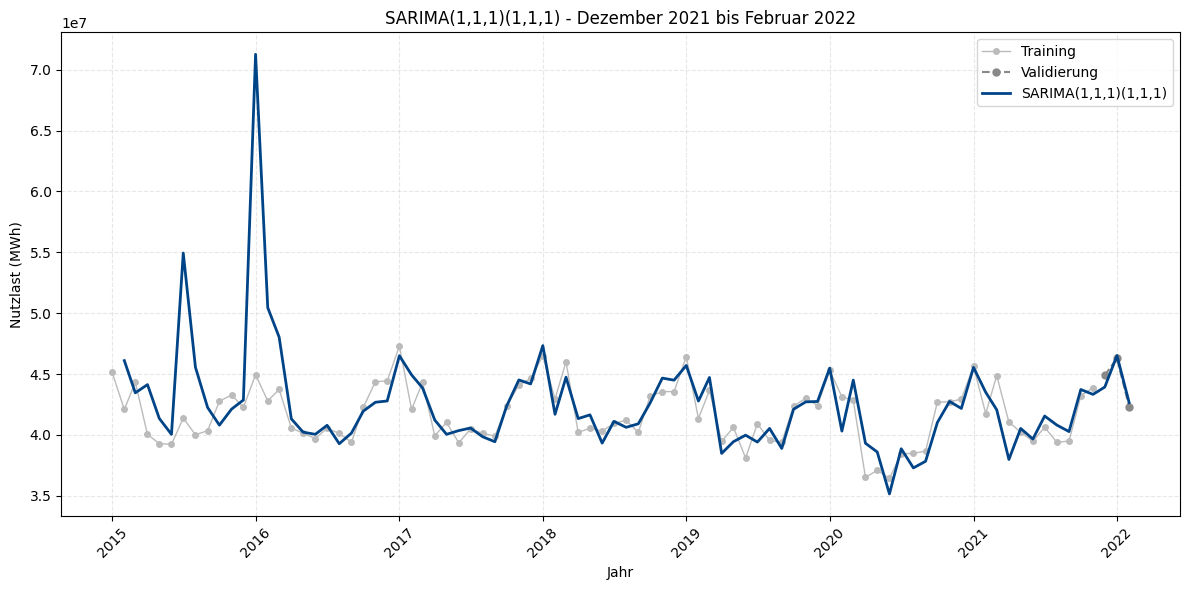

Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: 1.16%
Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: 514992.93


In [119]:
# SARIMA(1,1,1)(1,1,1)[6] Modell trainieren
sarima_model = SARIMAX(train_data, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 6), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Vorhersage über den gesamten Zeitraum
pred_sarima = sarima_fit.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_sarima_full = pred_sarima.predicted_mean

# Ersten Prognosewert ignorieren (wegen Differenzierung)
y_pred_sarima = y_pred_sarima_full[1:]
forecast_dates_sarima = df_monthly['date'][1:]

# Plot im gleichen Stil wie vorher
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# SARIMA Forecast – im Fokus
plt.plot(forecast_dates_sarima, y_pred_sarima, label='SARIMA(1,1,1)(1,1,1)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title("SARIMA(1,1,1)(1,1,1) - Dezember 2021 bis Februar 2022")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung auf Validierungszeitraum
valid_forecast_sarima = y_pred_sarima[-validation_range:]
mape_sarima = np.mean(np.abs((valid_data - valid_forecast_sarima) / valid_data)) * 100
mad_sarima = np.mean(np.abs(valid_data - valid_forecast_sarima))

# Ergebnisse speichern
model_results.append({
    'Modell': 'SARIMA(1,1,1)(1,1,1)[6]',
    'MAPE': round(mape_sarima, 2),
    'MAD': round(mad_sarima, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: {mape_sarima:.2f}%")
print(f"Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: {mad_sarima:.2f}")

## 12. SARIMA(1,1,0)(1,1,1)

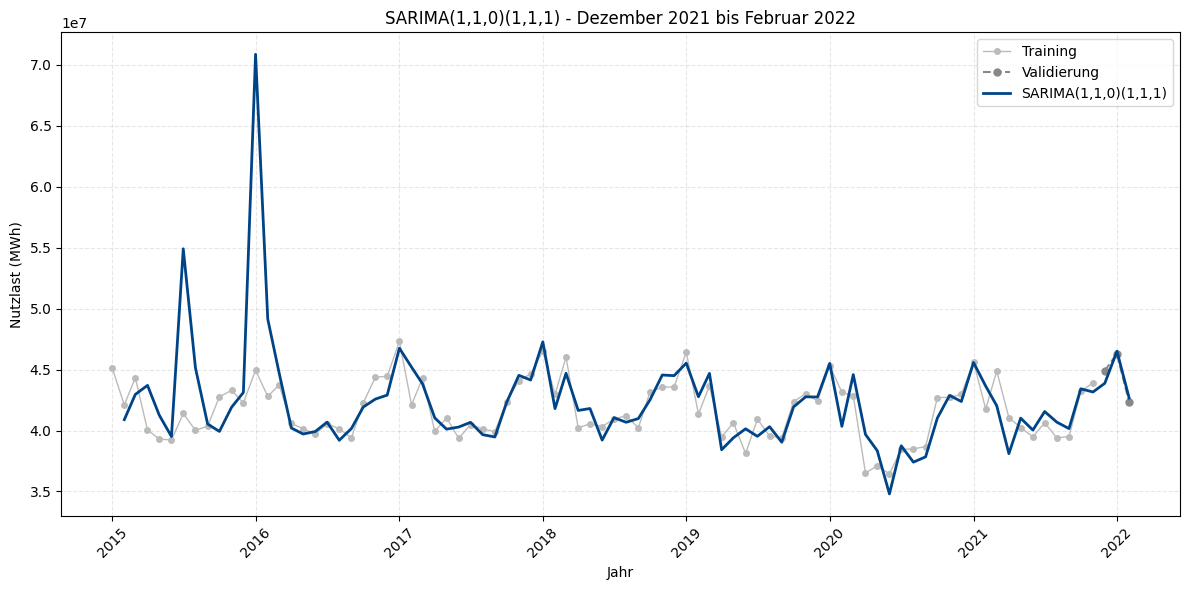

Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: 1.19%
Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: 530739.35


In [120]:
# SARIMA(1,1,1)(1,1,1)[6] Modell trainieren
sarima_model = SARIMAX(train_data, 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 1, 6), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Vorhersage über den gesamten Zeitraum
pred_sarima = sarima_fit.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_sarima_full = pred_sarima.predicted_mean

# Ersten Prognosewert ignorieren (wegen Differenzierung)
y_pred_sarima = y_pred_sarima_full[1:]
forecast_dates_sarima = df_monthly['date'][1:]

# Plotten im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# SARIMA-Vorhersage – im Fokus
plt.plot(forecast_dates_sarima, y_pred_sarima, label='SARIMA(1,1,0)(1,1,1)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('SARIMA(1,1,0)(1,1,1) - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Fehlerberechnung auf Validierungszeitraum
valid_forecast_sarima = y_pred_sarima[-validation_range:]
mape_sarima = np.mean(np.abs((valid_data - valid_forecast_sarima) / valid_data)) * 100
mad_sarima = np.mean(np.abs(valid_data - valid_forecast_sarima))

# Ergebnisse speichern
model_results.append({
    'Modell': 'SARIMA(1,1,0)(1,1,1)[6]',
    'MAPE': round(mape_sarima, 2),
    'MAD': round(mad_sarima, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: {mape_sarima:.2f}%")
print(f"Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: {mad_sarima:.2f}")

## 13. SARIMA(2,1,0)(1,1,1)

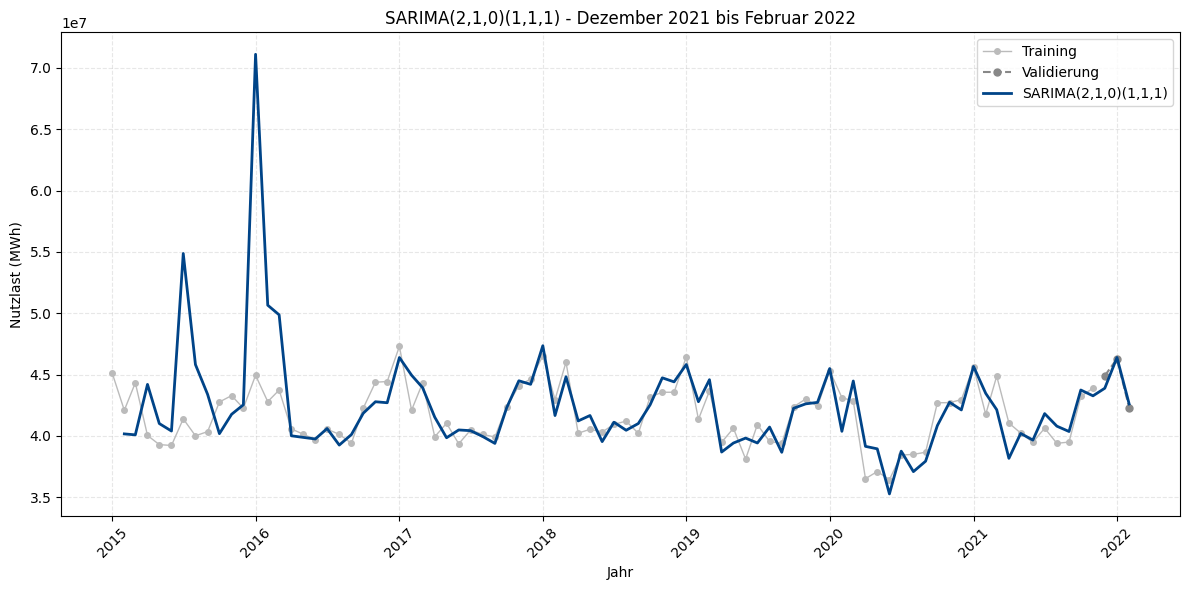

Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: 1.06%
Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: 470614.80


In [121]:
sarima_model = SARIMAX(train_data, 
                       order=(2, 1, 0), 
                       seasonal_order=(1, 1, 1, 6), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Vorhersage über den gesamten Zeitraum
pred_sarima = sarima_fit.get_prediction(start=series.index[0], end=series.index[-1])
y_pred_sarima_full = pred_sarima.predicted_mean

# Ersten Prognosewert ignorieren (wegen Differenzierung)
y_pred_sarima = y_pred_sarima_full[1:]
forecast_dates_sarima = df_monthly['date'][1:]

# Plotten im einheitlichen Stil
plt.figure(figsize=(12, 6))

# Trainingsdaten – dezent
plt.plot(df_monthly['date'][:-validation_range], train_data, label='Training', 
         marker='o', color='#BBBBBB', markersize=4, linestyle='-', linewidth=1)

# Validierungsdaten – leicht betont
plt.plot(df_monthly['date'][-validation_range:], valid_data, label='Validierung', 
         marker='o', color='#888888', markersize=5, linestyle='--', linewidth=1.5)

# SARIMA-Vorhersage – im Fokus
plt.plot(forecast_dates_sarima, y_pred_sarima, label='SARIMA(2,1,0)(1,1,1)', 
         color='#004488', linewidth=2)

plt.xlabel('Jahr')
plt.ylabel('Nutzlast (MWh)')
plt.title('SARIMA(2,1,0)(1,1,1) - Dezember 2021 bis Februar 2022')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Fehlerberechnung auf Validierungszeitraum
valid_forecast_sarima = y_pred_sarima[-validation_range:]
mape_sarima = np.mean(np.abs((valid_data - valid_forecast_sarima) / valid_data)) * 100
mad_sarima = np.mean(np.abs(valid_data - valid_forecast_sarima))

# Ergebnisse speichern
model_results.append({
    'Modell': 'SARIMA(2,1,0)(1,1,1)[6]',
    'MAPE': round(mape_sarima, 2),
    'MAD': round(mad_sarima, 2)
})

print(f"Mean Absolute Percentage Error (MAPE) - SARIMA(1,1,1)(1,1,1)[6]: {mape_sarima:.2f}%")
print(f"Mean Absolute Deviation (MAD) - SARIMA(1,1,1)(1,1,1)[6]: {mad_sarima:.2f}")

# 4. Performance der Modelle vergleichen

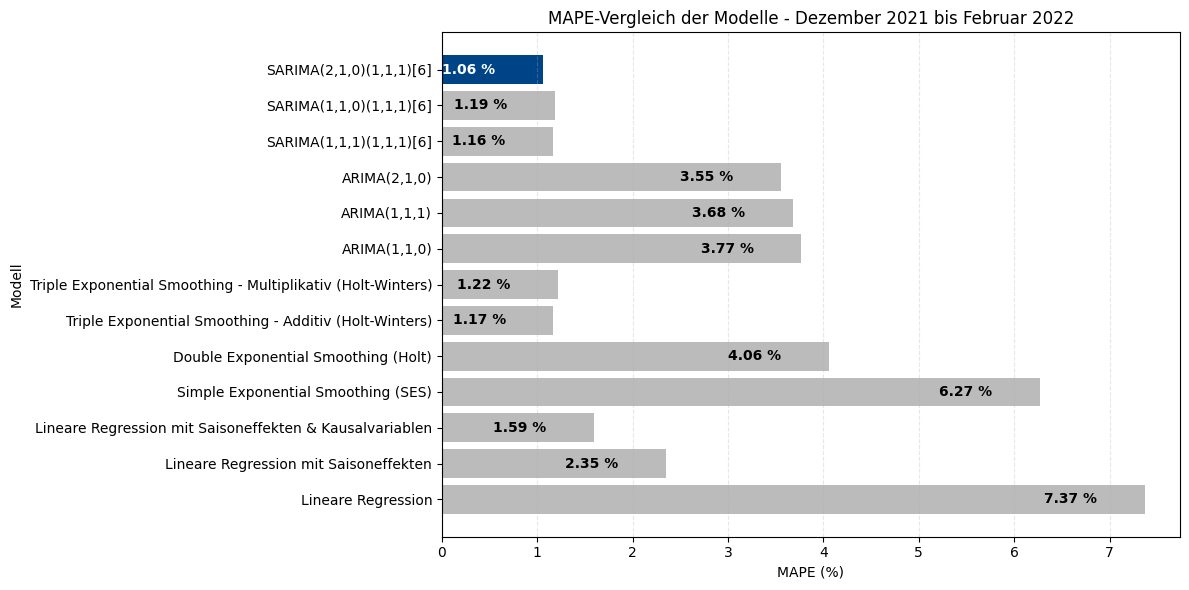

In [122]:
# Ergebnis-DataFrame erstellen
df_results = pd.DataFrame(model_results)

# Bestes Modell finden (kleinster MAPE-Wert)
best_index = df_results['MAPE'].idxmin()

# Einheitlicher Stil
plt.figure(figsize=(12, 6))

# Farben definieren
base_color = '#BBBBBB'
highlight_color = '#004488'
colors = [highlight_color if i == best_index else base_color for i in range(len(df_results))]

# Balken zeichnen
bars = plt.barh(df_results['Modell'], df_results['MAPE'], color=colors)

# Prozentwerte innerhalb der Balken platzieren
for i, bar in enumerate(bars):
    width = bar.get_width()
    text_color = 'white' if i == best_index else 'black'
    plt.text(width - 0.5, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f} %",
             va='center', ha='right', fontsize=10, color=text_color, fontweight='bold')

# Achsenbeschriftungen & Stil
plt.xlabel('MAPE (%)')
plt.ylabel('Modell')
plt.title('MAPE-Vergleich der Modelle - Dezember 2021 bis Februar 2022')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [123]:
# Speichern des DataFrames als CSV
df_results.to_csv('ergebnisse_-6.csv', index=False)